In [257]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

/kaggle/input/an-online-shop-business/Sales Transaction v.4a.csv


In [258]:
os.listdir('/kaggle/input/an-online-shop-business')

['Sales Transaction v.4a.csv']

In [259]:
data = pd.read_csv('/kaggle/input/an-online-shop-business/Sales Transaction v.4a.csv')

data.head(5)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [260]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


# Creating necessary columns

In [261]:
# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

# Year column
data['Year'] = pd.DatetimeIndex(data['Date']).year

# Month column
data['Month'] = pd.DatetimeIndex(data['Date']).month

data.head(5)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalAmount,Year,Month
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,2019,12
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,2019,12
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,2019,12
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,2019,12
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,2019,12


# Dropping null columns

In [262]:
# Validating null values
data.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
TotalAmount       0
Year              0
Month             0
dtype: int64

In [263]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price             0
Quantity       8585
TotalAmount    8585
dtype: int64

In [264]:
# Deleting all rows with null values
data = data.dropna(subset = ['CustomerNo'])

# Eliminating rows with negative quantities
data = data[data['Quantity'] >= 0]

In [265]:
# Validating null values again
data.isnull().sum()

TransactionNo    0
Date             0
ProductNo        0
ProductName      0
Price            0
Quantity         0
CustomerNo       0
Country          0
TotalAmount      0
Year             0
Month            0
dtype: int64

In [266]:
print(data['TotalAmount'].describe())
print(data['TotalAmount'].value_counts())

count    5.277640e+05
mean     1.193069e+02
std      1.851192e+03
min      5.130000e+00
25%      1.717000e+01
50%      4.383000e+01
75%      1.194000e+02
max      1.002718e+06
Name: TotalAmount, dtype: float64
TotalAmount
138.36     12942
6.19        9891
79.62       8710
14.48       8375
11.53       8260
           ...  
39.69          1
9261.00        1
2512.80        1
733.90         1
1094.63        1
Name: count, Length: 5626, dtype: int64


# Plotting the CLV

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='TotalAmount', ylabel='Percent'>

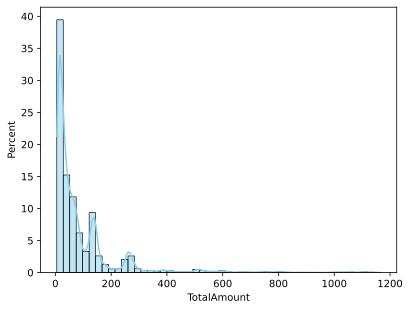

In [267]:
# Keep only values below the 99th percentile
filtered = data[data['TotalAmount'] < data['TotalAmount'].quantile(0.99)]

sns.histplot(filtered['TotalAmount'],bins=50, kde=True, color="skyblue", stat="percent")

# Dropping the columns that wont be used